# v5 - BN-relu

In [0]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

In [0]:
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.callbacks as cb
import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2, csv, shutil

# tf.keras.backend.set_learning_phase(True)

# 載入資料
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [0]:
IMAGE_SIZE = 300
BATCH_SIZE = 16
NUM_EPOCHS = 100
STEPS = 128
NUM_CLASSES = 3
DATASET_PATH = '/content/C1-P1_Train_Dev/C1-P1/'       # 資料路徑

In [0]:
def image_class():
    train_test_split = 0.2

    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/AIMango_sample/C1-P1_Train_Dev.zip")
    f.extractall("./")

    # 依分類建立資料夾
    if not os.path.isdir(DATASET_PATH + 'train'):
        os.mkdir(DATASET_PATH + 'train')
    if not os.path.isdir(DATASET_PATH + 'test'):
        os.mkdir(DATASET_PATH + 'test')
    if not os.path.isdir(DATASET_PATH + 'train/A'):
        os.mkdir(DATASET_PATH + 'train/A')
    if not os.path.isdir(DATASET_PATH + 'train/B'):
        os.mkdir(DATASET_PATH + 'train/B')
    if not os.path.isdir(DATASET_PATH + 'train/C'):
        os.mkdir(DATASET_PATH + 'train/C')
    if not os.path.isdir(DATASET_PATH + 'test/A'):
        os.mkdir(DATASET_PATH + 'test/A')
    if not os.path.isdir(DATASET_PATH + 'test/B'):
        os.mkdir(DATASET_PATH + 'test/B')
    if not os.path.isdir(DATASET_PATH + 'test/C'):
        os.mkdir(DATASET_PATH + 'test/C')
    
    with open('/content/C1-P1_Train_Dev/C1-P1.csv') as csvfile:
        rows = csv.reader(csvfile)

        level_path = {'A': [], 'B': [], 'C': []}
        for row in rows:
            level_path[row[1][-1]].append(DATASET_PATH + row[0])

        for lvl in level_path:            
            count = int(len(level_path[lvl]) * (1 - train_test_split))
            for i, img_path in enumerate(tqdm(level_path[lvl])):
                if i < count:
                    shutil.move(img_path, DATASET_PATH + 'train/' + lvl)
                else:
                    shutil.move(img_path, DATASET_PATH + 'test/' + lvl)

if not os.path.exists('/content/C1-P1_Train_Dev'):     
    image_class()

# 資料增強 ImageDataGenerator

In [0]:
def to_EMA(points, a=0.3):
    ret = []
    EMA = points[0]
    for pt in points:
        EMA = pt * a + EMA * (1 - a)
        ret.append(EMA)
    return ret

In [0]:
trn_dagen = ImageDataGenerator(rescale= 1. / 255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               channel_shift_range=10,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               dtype='float32')

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(rescale= 1./ 255,
                                   validation_split=0.5,
                                   dtype='float32')

val_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='training')
eva_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 5,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='validation')

Found 5119 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Found 639 images belonging to 3 classes.


# 動態設計 Learning rate

In [0]:
LR_START = 0.0001
# LR_MAX = 0.00005
# LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = cb.LearningRateScheduler(lrfn, verbose=True)

rl_callback = cb.ReduceLROnPlateau(monitor = "val_loss", 
                                   factor = 0.5, 
                                   patience = 10, 
                                   verbose = 0, 
                                   mode = "auto", 
                                   min_delta = 1e-07, 
                                   cooldown = 0, 
                                   min_lr = 1e-7)

es_callback = cb.EarlyStopping(patience=15, restore_best_weights=True)

# rng = [i for i in range(NUM_EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

callbacks = [lr_callback, 
             rl_callback, 
            #  es_callback
             ]

# CNN、FC 模型建立

In [0]:
net = efn.EfficientNetB5(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights= 'noisy-student',
                         include_top= False)

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-Relu
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.GlobalAveragePooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

# 模型編譯 optimizer、loss、metrics

In [0]:
import tensorflow.keras as K

model.compile(loss=K.losses.CategoricalCrossentropy(), 
              optimizer=K.optimizers.Adam(learning_rate=1e-3, amsgrad=True), 
              metrics=[K.metrics.CategoricalAccuracy()])

# 模型訓練

In [0]:
STEP_SIZE_TRAIN = trn_gen.n // NUM_EPOCHS
STEP_SIZE_VALID = val_gen.n // NUM_EPOCHS

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID,
                    callbacks= callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
51/51 [==============================] - 49s 967ms/step - loss: 0.9875 - categorical_accuracy: 0.5172 - val_loss: 0.9316 - val_categorical_accuracy: 0.5042 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/100
51/51 [==============================] - 45s 880ms/step - loss: 0.7332 - categorical_accuracy: 0.6814 - val_loss: 0.6758 - val_categorical_accuracy: 0.6875 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/100
51/51 [==============================] - 45s 881ms/step - loss: 0.7145 - categorical_accuracy: 0.7083 - val_loss: 0.6898 - val_categorical_accuracy: 0.6750 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/100
51/51 [==============================] - 45s 888ms/step - loss: 0.6938 - categorical_accuracy: 0.7034 - val_loss: 0.5767 - val_categor

In [0]:
import numpy as np

hv = to_EMA(history.history['val_categorical_accuracy'])
idx = np.argmax(hv)
acc = hv[idx]
print(f'使用資料擴增訓練 100 週期的 EMA 最佳週期為 {idx + 1}, 驗證準確率為 {acc}')

使用資料擴增訓練 100 週期的 EMA 最佳週期為 99, 驗證準確率為 0.8179286357578323


In [0]:
history.history['ema_categorical_accuracy'] = hv

# Plot accuracy

Text(0.5, 1.0, 'acc')

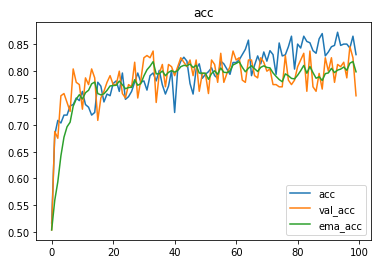

In [0]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['ema_categorical_accuracy'])
plt.legend(['acc', 'val_acc', 'ema_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

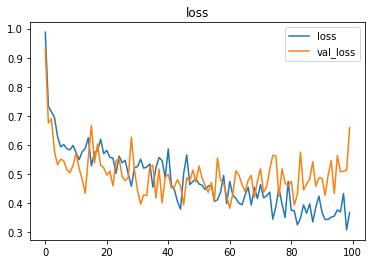

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# 評估模型

In [0]:
eva_x, eva_y = eva_gen.next()[0], eva_gen.next()[1]


In [0]:
loss, acc = model.evaluate(eva_gen, steps=STEPS)
print('評估的準確率: ', acc)

 16/128 [==>...........................] - 13s 798ms/step - loss: 0.4306 - categorical_accuracy: 0.8357
評估的準確率:  0.8356807231903076


In [0]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2
0,8,0,0
1,6,11,0
2,0,1,14
